In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hackerStats import dcst # Custom written hacker statistics functions

In [2]:
sns.set()

In [3]:
# Read data
df_2013 = pd.read_csv("dataSets/2013_FINA.csv", skiprows=4).dropna()

# Overview

Investigate whether the current experienced in the pool of 2013 FINA competition had effect on the swimmers agaisnt it, thus giving a advantage to the outer lanes swimming with the current on one side in favor of the outer lanes on the other side swimming against it.<br>

To investigate the effect of the current, the analysis considers only one directional 50 m races, since the pool is 50 m long<br>

If the pool is fair with no current, you'd see swimmers swimming in 1 through 3 (low-lanes) win, on average, as many medals as swimmers swimming in lanes 6 through 8 (High-lanes).<br>

If there is an equal chance of winning a medal in low-numbered lanes as in high-numbered lanes, then probability of wining medals in lanes 1 through 3 is binomially distributed with $p=0.5$.  

In 2013, however, 11 medals were awarded to swimmers in lanes 6 through 8, and only 1 medal in lanes 1 through 3.

In [4]:
binom_draws = np.random.binomial(12, 0.5, 1000)
print("Probability of winning 0 or 1 medal out 12 medals in low-numbered lanes: ", np.sum(binom_draws <= 1) / 1000)

Probability of winning 0 or 1 medal out 12 medals in low-numbered lanes:  0.003


# Improvement from low to high lane

There is little difference between semifinal and final performance of each swimmer (Refer to my notebook "analysis_2015_FINA").<br>

We can, therefore, neglect any differences due to it being the final versus the semifinal, and compare the data of each swimmer who switched from low lanes in semifinals to high lanes in finals, using data of all strokes.<br>

The ECDF Plot of a fractional imporvement metric when moving from a low lane to a high lane for the same swimmer, demonstrates that all but two of the 24 swimmers swam faster in the high numbered lanes.

In [5]:
def split_lane_swimtime(df):
    """
    Function returns two numpy arrays recording split swim time for each athlete, 
    who switched to high lane from low lanes in another round and vice versa
    """
    # Filter swimmers with who swam switched from high lanes in semifinals to low lanes in finals and vice versa, in 50m splitdistances
    # Split swim times are only taken from semi-finals and finals

    fifty_meters = (df['distance'] == 50)

    # Any swimmer who raced semi in low lanes and finals in high lanes
    lo_to_hi_conditions =(
        ((df['round'] == 'SEM') & (df['lane'].isin([1, 2, 3]))) | 
        ((df['round'] == 'FIN') & (df['lane'].isin([6, 7, 8])))
    )

    # Any swimmer who raced finals in low lanes and semi in high lanes
    hi_to_lo_conditions =(
        ((df['round'] == 'SEM') & (df['lane'].isin([6, 7, 8]))) | 
        ((df['round'] == 'FIN') & (df['lane'].isin([1, 2, 3])))
    )

    # Swimmers who were qualified to finals and switched from low to high lanes
    switch_lo_to_hi_df = (
        df[fifty_meters & lo_to_hi_conditions]
        .groupby('athleteid', as_index=False)
        .filter(lambda subframe : ('FIN' in subframe['round'].values) and ('SEM' in subframe['round'].values))

    )

    switch_lo_to_hi_df = pd.pivot_table(switch_lo_to_hi_df, values='splitswimtime', columns='round', index=['athleteid', 'stroke'], aggfunc=np.mean).dropna()

    # Swimmers who were qualified to finals and switched from high to low lanes
    switch_hi_to_lo_df = (
        df[fifty_meters & hi_to_lo_conditions]
        .groupby('athleteid', as_index=False)
        .filter(lambda subframe : ('FIN' in subframe['round'].values) and ('SEM' in subframe['round'].values))

    )

    switch_hi_to_lo_df = pd.pivot_table(switch_hi_to_lo_df, values='splitswimtime', columns='round', index=['athleteid', 'stroke'], aggfunc=np.mean).dropna()

    swimtime_low_lanes = np.concatenate((switch_lo_to_hi_df['SEM'].to_numpy(), switch_hi_to_lo_df['FIN'].to_numpy()))
    swimtime_high_lanes = np.concatenate((switch_lo_to_hi_df['FIN'].to_numpy(), switch_hi_to_lo_df['SEM'].to_numpy()))

    return swimtime_low_lanes, swimtime_high_lanes

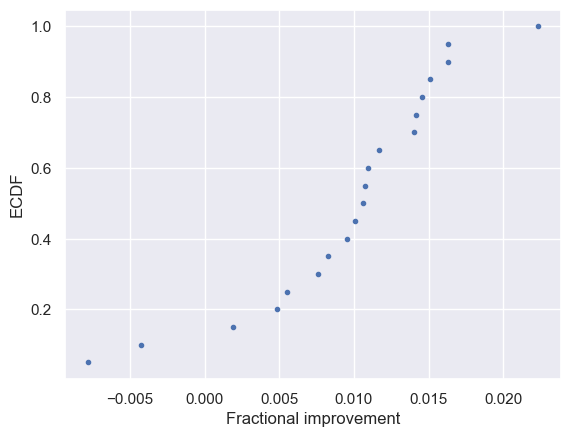

In [6]:
swimtime_low_lanes, swimtime_high_lanes = split_lane_swimtime(df_2013) 
# Compute the fractional improvement of being in high lane: f
f = (swimtime_low_lanes - swimtime_high_lanes) / swimtime_low_lanes

# Make x and y values for ECDF: x, y
x, y = dcst.ecdf(f)

# Plot the ECDFs as dots
plt.plot(x, y, marker='.', linestyle="none")

# Label the axes and show the plot
plt.xlabel('Fractional improvement')
plt.ylabel('ECDF')
plt.show()

## Estimation of mean improvement

In [7]:
# Compute the mean difference: f_mean
f_mean = np.mean(f)

# Draw 10,000 bootstrap replicates: bs_reps
bs_reps = dcst.draw_bs_reps(f, np.mean, 10 ** 4)

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_reps, [2.5, 97.5])

# Print the result
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]""".format(f_mean, *conf_int))


mean frac. diff.: 0.00962
95% conf int of mean frac. diff.: [0.00645, 0.01249]


## Hypothesis test: Does lane assignment affect performance?

To see whether lane assignment really does affect performance, then next code-cell performs a bootstrap hypothesis test with a null hypothesis that the mean fractional improvement going from low-numbered lanes to high-numbered lanes is zero, and compares it to the mean value obtained above.

In [8]:
# Shift the metric array so that it would have a mean of zero
f_shift = f - f_mean

# Draw 100,000 bootstrap replicates of the mean: bs_reps
bs_reps = dcst.draw_bs_reps(f_shift, np.mean, 10 ** 5)

# Compute and report the p-value
p_val = np.sum(bs_reps >= f_mean) / 100000
print('p =', p_val)

p = 0.0


## Did the 2015 event have this problem?

Both the confidence interval and the p-value suggest that there was no lane bias in 2015.

In [9]:
# Load 2015 FINA data
df_2015 = pd.read_csv("datasets/2015_FINA.csv", skiprows=4).dropna() 
swimtime_low_lanes_15, swimtime_high_lanes_15 = split_lane_swimtime(df_2015)

In [10]:
# Compute f and its mean
f = (swimtime_low_lanes_15 - swimtime_high_lanes_15) / swimtime_low_lanes_15
f_mean = np.mean(f)

# Draw 10,000 bootstrap replicates
bs_reps = dcst.draw_bs_reps(f, np.mean, 10 ** 4)

# Compute 95% confidence interval
conf_int = np.percentile(bs_reps, [2.5, 97.5])

# Shift f
f_shift = f - f_mean

# Draw 100,000 bootstrap replicates of the mean
bs_reps = dcst.draw_bs_reps(f_shift, np.mean, 10 ** 5)

# Compute the p-value
p_val = np.sum(bs_reps >= f_mean) / 100000

# Print the results
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]
p-value: {3:.5f}""".format(f_mean, *conf_int, p_val))


mean frac. diff.: 0.00136
95% conf int of mean frac. diff.: [-0.00280, 0.00507]
p-value: 0.26223
